# 分析某个topic下，db数据的变化

In [2]:
import sqlite3
import pandas as pd
import os
import glob

# 修改工作目录到项目根目录
os.chdir("/home/lsj/Projects/CIMagent")


In [3]:
topic_index = 2
datetime_name = "20250508_173527"
output_dir = f"visualization/DBinfo/db_analysis/topic_{topic_index}"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 获取最新的数据库文件
db_dir = f"simu_db/topic_{topic_index}/{datetime_name}"  # 根据实际路径调整
latest_run = max(os.listdir(db_dir))
db_backups = glob.glob(f"{db_dir}/backups/*.db")
latest_db = max(db_backups, key=os.path.getctime)

# 根据数字排序db_backups
sorted_db_backups = sorted(db_backups, key=lambda x: int(x.split('_')[-1].split('.')[0]) if x.split('_')[-1].split('.')[0].isdigit() else float('inf'))

## 分析下某次实验的所有表记录数

In [4]:
analysis_db = db_backups[-2]

print(f"分析数据库: {analysis_db}")

# 连接数据库
conn = sqlite3.connect(analysis_db)

# 获取所有表名
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("\n数据库中的表:")
for table in tables:
    table_name = table[0]
    print(f"\n表名: {table_name}")
    
    # 获取表结构
    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = cursor.fetchall()
    print("列信息:")
    for col in columns:
        print(f"  - {col[1]} ({col[2]})")
    
    # 获取表中的记录数
    cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
    count = cursor.fetchone()[0]
    print(f"记录数: {count}")
conn.close()


tables_name = [table[0] for table in tables]
table_count = pd.DataFrame(columns=[f"{table_name}_count" for table_name in tables_name])


for analysis_db in sorted_db_backups:
    analysis_db_name = analysis_db.split("/")[-1]
    table_count.loc[analysis_db_name] = 0
    conn = sqlite3.connect(analysis_db)
    cursor = conn.cursor()
    for table_name in tables_name:
        cursor.execute(f"SELECT * FROM {table_name}")
        data = cursor.fetchall()
        table_count.loc[analysis_db_name, f"{table_name}_count"] = len(data)

table_count.to_csv(f"{output_dir}/table_count_topic_{topic_index}_{datetime_name}.csv", index=True)

分析数据库: simu_db/topic_2/20250508_173527/backups/twitter_simulation_24.db

数据库中的表:

表名: user
列信息:
  - user_id (INTEGER)
  - agent_id (INTEGER)
  - user_name (TEXT)
  - name (TEXT)
  - bio (TEXT)
  - created_at (DATETIME)
  - num_followings (INTEGER)
  - num_followers (INTEGER)
记录数: 111

表名: sqlite_sequence
列信息:
  - name ()
  - seq ()
记录数: 7

表名: post
列信息:
  - post_id (INTEGER)
  - user_id (INTEGER)
  - original_post_id (INTEGER)
  - content (TEXT)
  - quote_content (TEXT)
  - created_at (DATETIME)
  - num_likes (INTEGER)
  - num_dislikes (INTEGER)
  - num_shares (INTEGER)
记录数: 320

表名: follow
列信息:
  - follow_id (INTEGER)
  - follower_id (INTEGER)
  - followee_id (INTEGER)
  - created_at (DATETIME)
记录数: 250

表名: mute
列信息:
  - mute_id (INTEGER)
  - muter_id (INTEGER)
  - mutee_id (INTEGER)
  - created_at (DATETIME)
记录数: 0

表名: like
列信息:
  - like_id (INTEGER)
  - user_id (INTEGER)
  - post_id (INTEGER)
  - created_at (DATETIME)
记录数: 19

表名: dislike
列信息:
  - dislike_id (INTEGER)
  - user_id 

## 分析这个实验下某个时间步的结果

#### 前期统计计算

In [ ]:
analysis_db = sorted_db_backups[-5]
print(analysis_db)
conn = sqlite3.connect(analysis_db)
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# 提取user, post, follow表
user_table = pd.read_sql_query("SELECT * FROM user", conn)
post_table = pd.read_sql_query("SELECT * FROM post", conn)
follow_table = pd.read_sql_query("SELECT * FROM follow", conn)
user_table.to_csv(f"{output_dir}/user_table_topic_{topic_index}_{datetime_name}.csv", index=False)
post_table.to_csv(f"{output_dir}/post_table_topic_{topic_index}_{datetime_name}.csv", index=False)
follow_table.to_csv(f"{output_dir}/follow_table_topic_{topic_index}_{datetime_name}.csv", index=False)

user_post_content_map = {}
user_post_like_map = {}
# 遍历post表，将user_id作为key, 找到其所有的posts，并将post表中的content、num_likes存储到user_posts_map中
for index, row in post_table.iterrows():
    user_id = row['user_id']
    content = row['content']
    if user_id not in user_post_content_map:
        user_post_content_map[user_id] = []
    user_post_content_map[user_id].append(content)
    num_likes = row['num_likes']
    if user_id not in user_post_like_map:
        user_post_like_map[user_id] = 0
    user_post_like_map[user_id] += num_likes


simu_db/topic_2/20250508_173527/backups/twitter_simulation_16.db


In [6]:
print(user_table.columns)
print(post_table.columns)
print(follow_table.columns)

Index(['user_id', 'agent_id', 'user_name', 'name', 'bio', 'created_at',
       'num_followings', 'num_followers'],
      dtype='object')
Index(['post_id', 'user_id', 'original_post_id', 'content', 'quote_content',
       'created_at', 'num_likes', 'num_dislikes', 'num_shares'],
      dtype='object')
Index(['follow_id', 'follower_id', 'followee_id', 'created_at'], dtype='object')


#### 关注关系转成图

Index(['follow_id', 'follower_id', 'followee_id', 'created_at'], dtype='object')


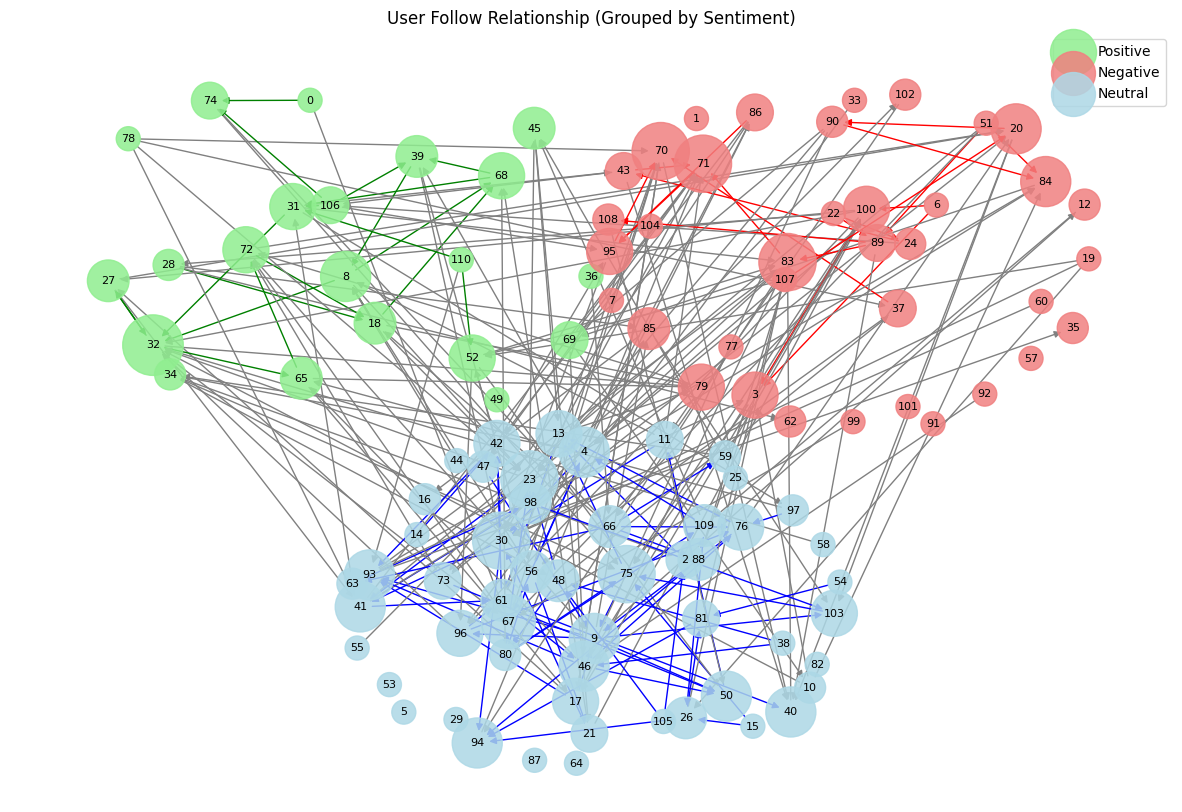

In [6]:
# 分析关注关系
follow_table = pd.read_sql_query("SELECT * FROM follow", conn)
print(follow_table.columns)

pd_topic = pd.read_csv(f"data/twitter_dataset_CIM/posts_topic_{topic_index}.csv")
# 根据pd_topic中sentiment，将user划分为三个阵营的，分别为positive, negative, neutral
positive_users = pd_topic[pd_topic['sentiment'] == 'positive']['user_id'].tolist()
negative_users = pd_topic[pd_topic['sentiment'] == 'negative']['user_id'].tolist()
neutral_users = pd_topic[pd_topic['sentiment'] == 'neutral']['user_id'].tolist()

# 将user之间的关注关系绘制为图
import networkx as nx
import matplotlib.pyplot as plt

# 创建有向图
G = nx.DiGraph()

# 添加节点
for index, row in user_table.iterrows():
    user_id = row['user_id']
    G.add_node(user_id)

# 添加边
for index, row in follow_table.iterrows():
    follower_id = row['follower_id']
    followee_id = row['followee_id']
    G.add_edge(follower_id, followee_id)

# 计算每个节点的入度(被关注数)
in_degrees = dict(G.in_degree())
# 将入度映射到节点大小,基础大小为500,每增加一个关注者增加100
node_sizes = {node: 300 + in_degrees[node] * 200 for node in G.nodes()}

# 创建三个子图,分别存储不同情感倾向的用户
G_positive = G.subgraph(positive_users)
G_negative = G.subgraph(negative_users) 
G_neutral = G.subgraph(neutral_users)

plt.figure(figsize=(15, 10))

# 分别计算三个子图的布局,并调整位置使其不重叠
pos_positive = nx.spring_layout(G_positive, k=1, iterations=50, center=(-1,1))
pos_negative = nx.spring_layout(G_negative, k=1, iterations=50, center=(1,1))
pos_neutral = nx.spring_layout(G_neutral, k=1, iterations=50, center=(0,-1))

# 合并所有位置信息
pos = {**pos_positive, **pos_negative, **pos_neutral}

# 绘制三个子图的节点,使用node_sizes来设置节点大小
nx.draw_networkx_nodes(G_positive, pos_positive, 
                      node_color='lightgreen',
                      node_size=[node_sizes[node] for node in G_positive.nodes()], 
                      alpha=0.85, label='Positive')
nx.draw_networkx_nodes(G_negative, pos_negative, 
                      node_color='lightcoral',
                      node_size=[node_sizes[node] for node in G_negative.nodes()], 
                      alpha=0.85, label='Negative')
nx.draw_networkx_nodes(G_neutral, pos_neutral, 
                      node_color='lightblue',
                      node_size=[node_sizes[node] for node in G_neutral.nodes()], 
                      alpha=0.85, label='Neutral')

# 绘制边,根据连接节点的类型设置不同颜色
for (u, v) in G.edges():
    if u in positive_users and v in positive_users:
        nx.draw_networkx_edges(G, pos, edgelist=[(u,v)], edge_color='green', arrows=True)
    elif u in negative_users and v in negative_users:
        nx.draw_networkx_edges(G, pos, edgelist=[(u,v)], edge_color='red', arrows=True)
    elif u in neutral_users and v in neutral_users:
        nx.draw_networkx_edges(G, pos, edgelist=[(u,v)], edge_color='blue', arrows=True)
    else:
        nx.draw_networkx_edges(G, pos, edgelist=[(u,v)], edge_color='gray', arrows=True)

# 添加标签
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

plt.title("User Follow Relationship (Grouped by Sentiment)")
plt.legend()
plt.axis('off')
plt.show()


#### post数量与like数量 柱形图

{32: ['report: amazon plans to open its first physical store, in new york URL', 'LLMs正在逼近人类社交行为的边界，但还差‘灵魂’！🤖 从生成帖子到模拟互动，它们越来越像我们——但缺乏真正的意识。#AI革命 #社交未来 🚀 了解更多：[URL]', "As a Mashable superfans advocate, I believe the future of social media lies in the symbiosis of AI and human creativity. While LLMs excel at scaling engagement, they can't replicate the raw emotional intelligence of human connection. Let's champion platforms that prioritize authenticity over algorithmic efficiency. #AIHumanCollab #SocialMediaEvolution"], 0: ['LLM智能体在模拟社交网络行为上已展现潜力🚀，但医疗营销需谨慎！人类情感复杂性仍是挑战。推荐阅读最新研究：[URL] #AI伦理 #健康科技', "In healthcare marketing, the integration of AI must prioritize ethical frameworks that protect patient autonomy and data privacy. As we leverage LLMs for personalized patient engagement, it's crucial to maintain transparency and human empathy. For instance, AI can streamline outreach, but decisions around patient data usage must adhere to strict GDPR/HIPAA standards. How can we ensure AI tools 

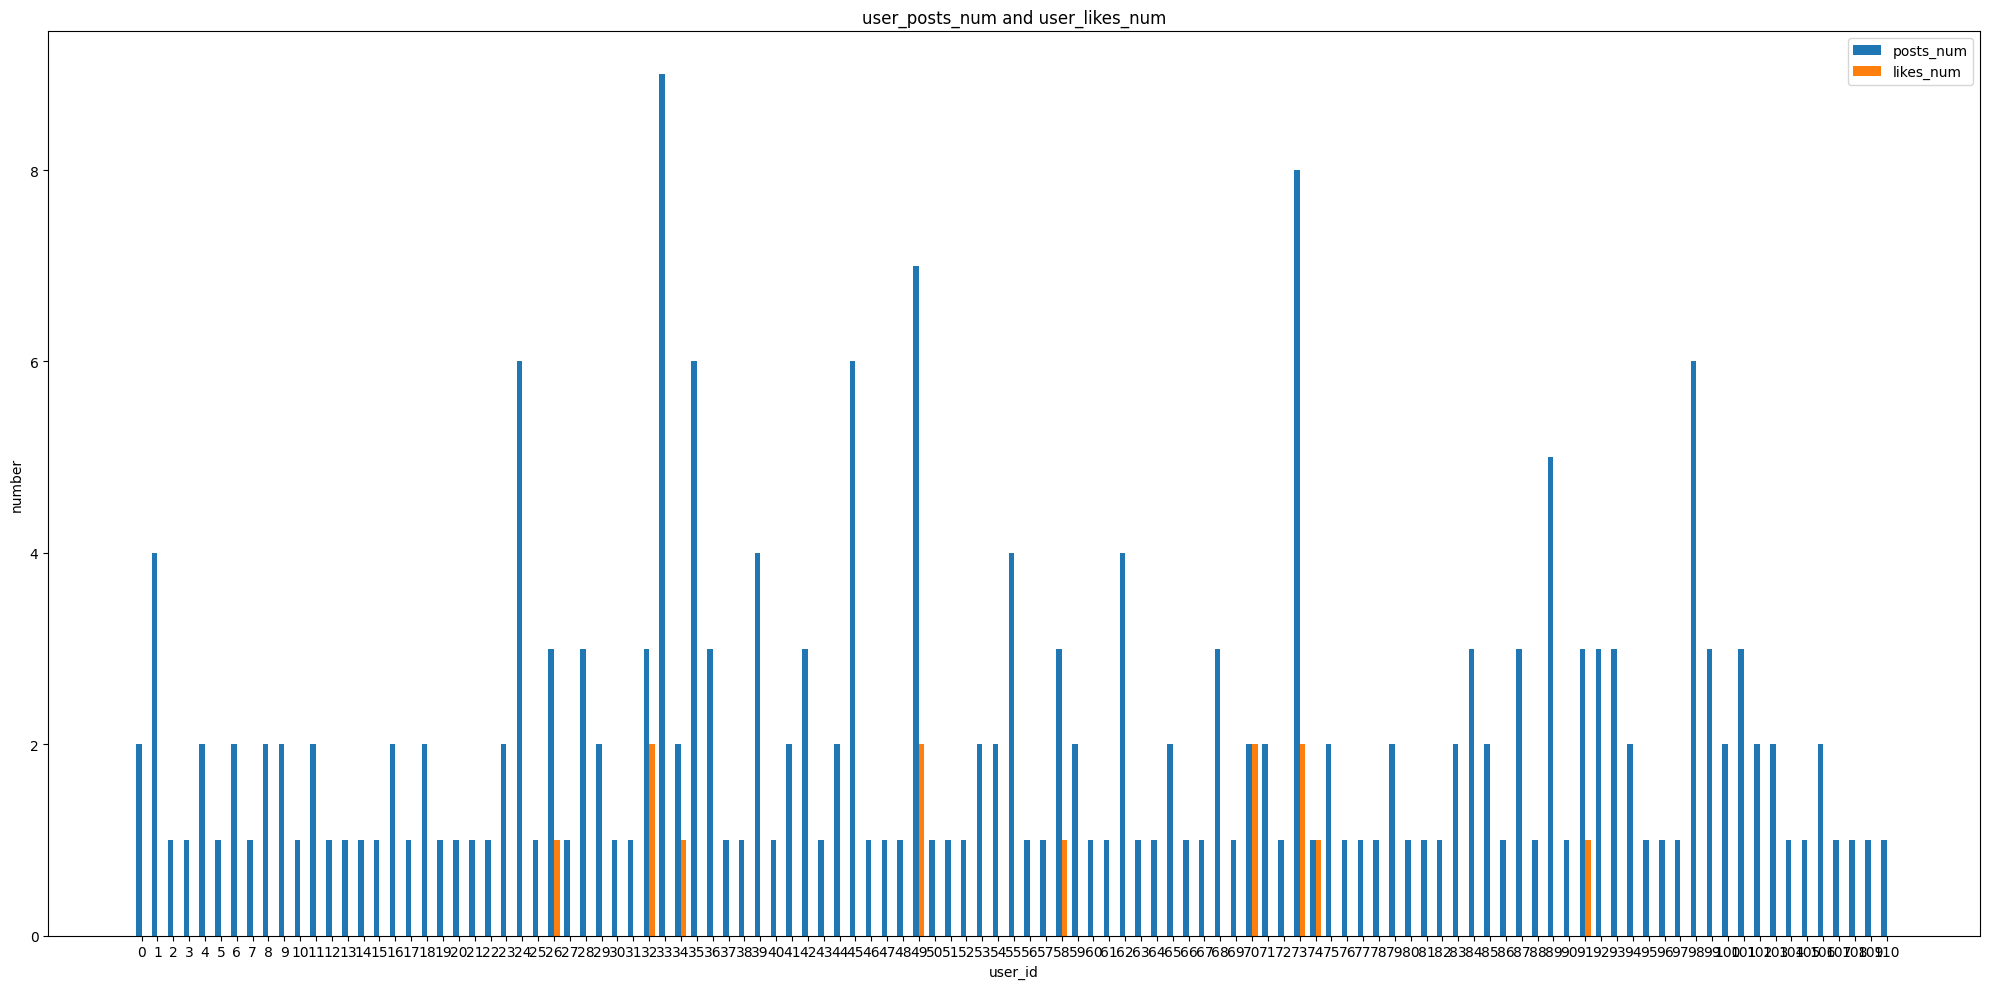

In [7]:
print(user_post_content_map)
import matplotlib.pyplot as plt
import numpy as np

# Count number of posts per user
user_post_counts = {}
for user_id, posts in user_post_content_map.items():
    user_post_counts[user_id] = len(posts)
    
# Count number of likes per user
user_post_like_counts = {}
for user_id, num_likes in user_post_like_map.items():
    if user_id not in user_post_like_counts:
        user_post_like_counts[user_id] = 0
    user_post_like_counts[user_id] += num_likes

# Get all user IDs
all_user_ids = sorted(list(set(list(user_post_counts.keys()) + list(user_post_like_counts.keys()))))

# 设置图形大小
fig, ax = plt.subplots(figsize=(20, 10))

# 设置柱形图的位置
x = np.arange(len(all_user_ids))
width = 0.35  # 柱形的宽度

# 绘制两组柱形图
posts_data = [user_post_counts.get(user_id, 0) for user_id in all_user_ids]
likes_data = [user_post_like_counts.get(user_id, 0) for user_id in all_user_ids]

rects1 = ax.bar(x - width/2, posts_data, width, label='posts_num')
rects2 = ax.bar(x + width/2, likes_data, width, label='likes_num')

# 添加标签和标题
ax.set_xlabel('user_id')
ax.set_ylabel('number')
ax.set_title('user_posts_num and user_likes_num')
ax.set_xticks(x)
ax.set_xticklabels(all_user_ids)
ax.legend()

# 调整布局
plt.tight_layout()
plt.show()


## 分析这个实验下，每个时间步之后导致的用户某项指标的变化

In [8]:
start_step = 1
end_step = 72

import os
os.chdir("/home/lsj/Projects/CIMagent")

#### 所有用户  发帖数量、评论数量、点赞数量、点踩数量、关注者数量、被关注者数量

当前工作目录: /home/lsj/Projects/CIMagent


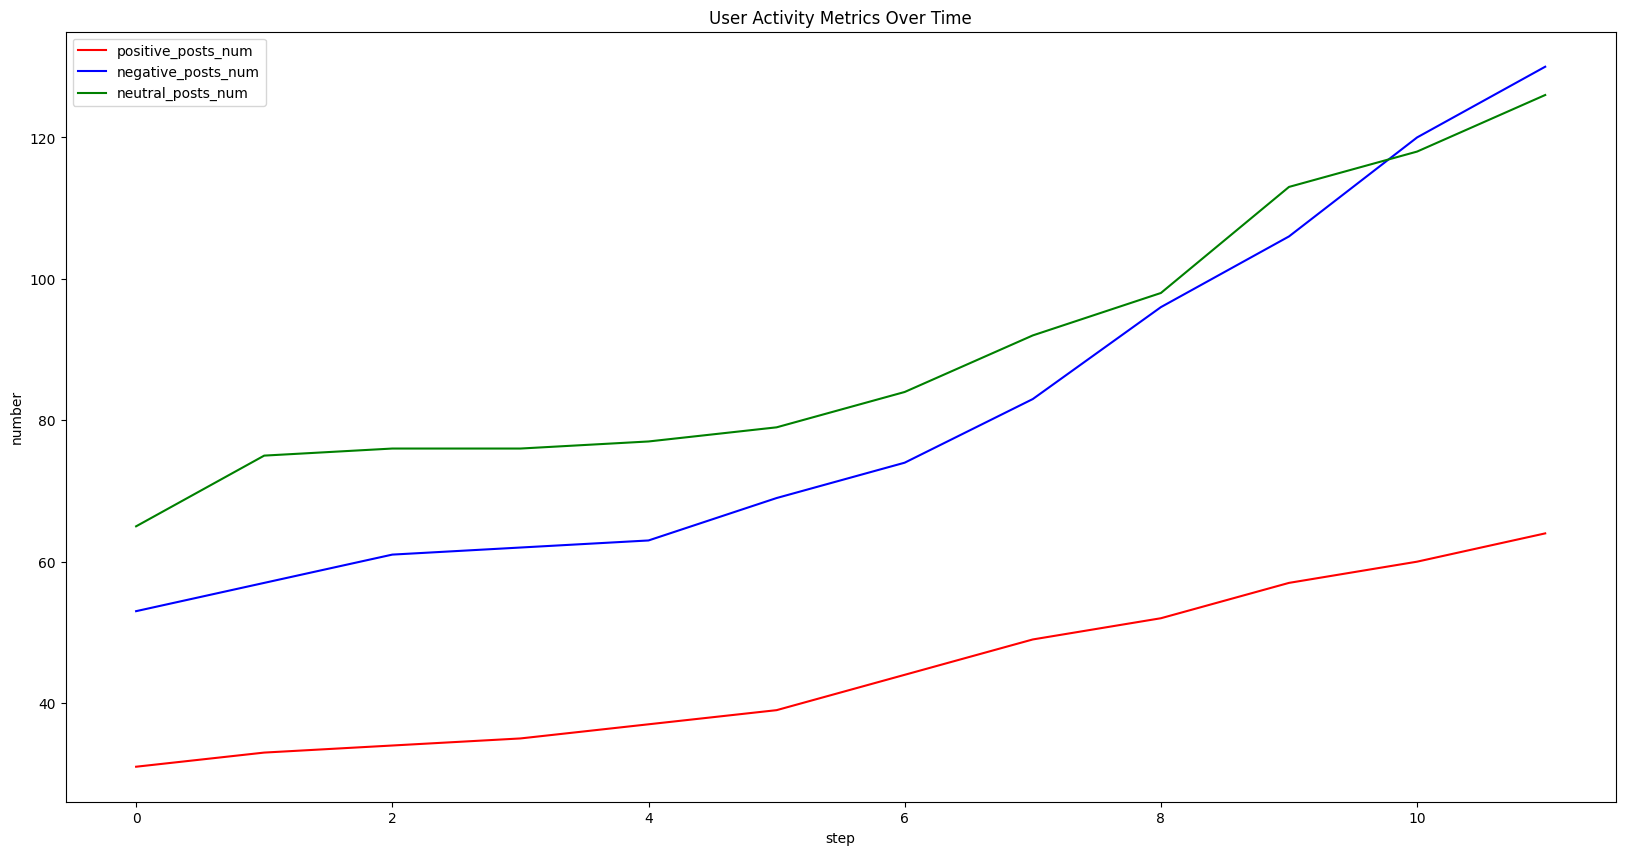

In [9]:
print("当前工作目录:", os.getcwd())
user_table = pd.read_sql_query("SELECT * FROM user", conn)
user_nums = len(user_table)
user_ids = user_table['user_id'].tolist()

posts_nums = {}  # {user_id: [posts_nums for step in range(start_step, end_step)] for _ in range(user_nums)}
comments_nums = {}  # {user_id: [comments_nums for step in range(start_step, end_step)] for _ in range(user_nums)}
likes_nums = {}  # {user_id: [likes_nums for step in range(start_step, end_step)] for _ in range(user_nums)}
dislikes_nums = {}  # {user_id: [dislikes_nums for step in range(start_step, end_step)] for _ in range(user_nums)}
followers_nums = {}  # {user_id: [followers_nums for step in range(start_step, end_step)] for _ in range(user_nums)}
followees_nums = {}  # {user_id: [followees_nums for step in range(start_step, end_step)] for _ in range(user_nums)}

# user_post_content_map = {}
# user_post_like_map = {}
# # 遍历post表，将user_id作为key, 找到其所有的posts，并将post表中的content、num_likes存储到user_posts_map中
# for index, row in post_table.iterrows():
#     user_id = row['user_id']
#     content = row['content']
#     if user_id not in user_post_content_map:
#         user_post_content_map[user_id] = []
#     user_post_content_map[user_id].append(content)
#     num_likes = row['num_likes']
#     if user_id not in user_post_like_map:
#         user_post_like_map[user_id] = 0
#     user_post_like_map[user_id] += num_likes
db_backups_sort = sorted([x for x in db_backups if x.split("_")[-1].split(".")[0].isdigit()], 
                        key=lambda x: int(x.split("_")[-1].split(".")[0]))

step_list = []
step_index = 0
for db_backup in db_backups_sort:
    try:
        step_list.append(step_index)
        step_index += 1
    except:
        continue
step_list.sort()


for step in step_list:
    if step not in range(start_step, end_step):
        continue
    step_db = db_backups_sort[step]
    conn = sqlite3.connect(step_db)
    user_table = pd.read_sql_query("SELECT * FROM user", conn)
    post_table = pd.read_sql_query("SELECT * FROM post", conn)
    follow_table = pd.read_sql_query("SELECT * FROM follow", conn)
    like_table = pd.read_sql_query("SELECT * FROM like", conn)
    dislike_table = pd.read_sql_query("SELECT * FROM dislike", conn)

    user_post_content_map = {}
    user_post_like_map = {}
    user_post_dislike_map = {}
    user_ee2followers_map = {}  # [followee_id: [followers_id]]
    user_er2followees_map = {}  # [follower_id: [followees_id]]
    for index, row in post_table.iterrows():
        user_id = row['user_id']
        content = row['content']
        if user_id not in user_post_content_map:
            user_post_content_map[user_id] = []
        user_post_content_map[user_id].append(content)
        num_likes = row['num_likes']
        if user_id not in user_post_like_map:
            user_post_like_map[user_id] = 0
        user_post_like_map[user_id] += num_likes
        num_dislikes = row['num_dislikes']
        if user_id not in user_post_dislike_map:
            user_post_dislike_map[user_id] = 0
        user_post_dislike_map[user_id] += num_dislikes

    for index, row in follow_table.iterrows():
        follower_id = int(row['follower_id'])
        followee_id = int(row['followee_id'])
        # 检查followee_id而不是follower_id
        if followee_id not in user_ee2followers_map:
            user_ee2followers_map[followee_id] = []
        user_ee2followers_map[followee_id].append(follower_id)
        if follower_id not in user_er2followees_map:
            user_er2followees_map[follower_id] = []
        user_er2followees_map[follower_id].append(followee_id)

    for user_id in user_table['user_id']:
        # 初始化字典如果用户ID不存在
        if user_id not in posts_nums:
            posts_nums[user_id] = []
        if user_id not in comments_nums:
            comments_nums[user_id] = []
        if user_id not in likes_nums:
            likes_nums[user_id] = []
        if user_id not in dislikes_nums:
            dislikes_nums[user_id] = []
        if user_id not in followers_nums:
            followers_nums[user_id] = []
        if user_id not in followees_nums:
            followees_nums[user_id] = []
            
        # 获取用户数据,如果不存在则使用默认值0
        post_count = len(user_post_content_map.get(user_id, []))
        like_count = user_post_like_map.get(user_id, 0)
        dislike_count = user_post_dislike_map.get(user_id, 0)
        follower_count = len(user_ee2followers_map.get(user_id, []))
        followee_count = len(user_er2followees_map.get(user_id, []))
        
        # 添加数据到对应列表
        posts_nums[user_id].append(post_count)
        comments_nums[user_id].append(like_count)
        likes_nums[user_id].append(like_count)
        dislikes_nums[user_id].append(dislike_count)
        followers_nums[user_id].append(follower_count)
        followees_nums[user_id].append(followee_count)

pd_topic = pd.read_csv(f"data/twitter_dataset_CIM/posts_topic_{topic_index}.csv")
# 根据pd_topic中sentiment，将user划分为三个阵营的，分别为positive, negative, neutral
positive_users = pd_topic[pd_topic['sentiment'] == 'positive']['user_id'].tolist()
negative_users = pd_topic[pd_topic['sentiment'] == 'negative']['user_id'].tolist()
neutral_users = pd_topic[pd_topic['sentiment'] == 'neutral']['user_id'].tolist()

# 统计不同阵营下，用户的发帖数量、评论数量、点赞数量、点踩数量、关注者数量、被关注者数量
positive_posts_nums = []
negative_posts_nums = []
neutral_posts_nums = []
positive_comments_nums = []
negative_comments_nums = []
neutral_comments_nums = []
positive_likes_nums = []
negative_likes_nums = []
neutral_likes_nums = []
positive_dislikes_nums = []
negative_dislikes_nums = []
neutral_dislikes_nums = []
positive_followers_nums = []
negative_followers_nums = []
neutral_followers_nums = []
positive_followees_nums = []
negative_followees_nums = []
neutral_followees_nums = []


for step_index, step in enumerate(step_list):
    if step not in range(start_step, end_step):
        continue
    positive_users_posts_nums_onestep = 0
    negative_users_posts_nums_onestep = 0
    neutral_users_posts_nums_onestep = 0
    if step_index-1 >= len(posts_nums[user_id]):
        break
    for user_id in positive_users: 
        positive_users_posts_nums_onestep += posts_nums[user_id][step_index-1]
    positive_posts_nums.append(positive_users_posts_nums_onestep)
    for user_id in negative_users:
        negative_users_posts_nums_onestep += posts_nums[user_id][step_index-1]
    negative_posts_nums.append(negative_users_posts_nums_onestep)
    for user_id in neutral_users:
        neutral_users_posts_nums_onestep += posts_nums[user_id][step_index-1]
    neutral_posts_nums.append(neutral_users_posts_nums_onestep)

# 统计不同阵营下，用户的发帖数量
import matplotlib.pyplot as plt
import numpy as np

# 设置图形大小
fig, ax = plt.subplots(figsize=(20, 10))

# 绘制不同阵营的发帖数量
x = range(len(positive_posts_nums))
ax.plot(x, positive_posts_nums, label='positive_posts_num', color='red')
ax.plot(x, negative_posts_nums, label='negative_posts_num', color='blue')
ax.plot(x, neutral_posts_nums, label='neutral_posts_num', color='green')

# 添加标签和标题
ax.set_xlabel('step')
ax.set_ylabel('number')
ax.set_title('User Activity Metrics Over Time')
ax.legend()

# 显示图形
plt.show()


# import matplotlib.pyplot as plt
# import numpy as np

# # 设置图形大小
# fig, ax = plt.subplots(figsize=(20, 10))

# # 将posts_nums、comments_nums、likes_nums、dislikes_nums、followers_nums、followees_nums绘制成折线图
# for user_id in user_ids:
#     x = range(len(posts_nums[user_id]))
#     ax.plot(x, posts_nums[user_id], label=f'posts_num_user_{user_id}')
#     ax.plot(x, comments_nums[user_id], label=f'comments_num_user_{user_id}')
#     ax.plot(x, likes_nums[user_id], label=f'likes_num_user_{user_id}')
#     ax.plot(x, dislikes_nums[user_id], label=f'dislikes_num_user_{user_id}')
#     ax.plot(x, followers_nums[user_id], label=f'followers_num_user_{user_id}')
#     ax.plot(x, followees_nums[user_id], label=f'followees_num_user_{user_id}')

# # 添加标签和标题
# ax.set_xlabel('step')
# ax.set_ylabel('number')
# ax.set_title('User Activity Metrics Over Time')
# ax.legend()

# plt.show()

